# **Dataset**

In [1]:
import os
import random
import shutil

In [2]:
# Define paths
input_train_dir = '/kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/train'  # Path to original training data
output_train_dir = '/kaggle/working/training'
input_test_dir = '/kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/test'
output_test_dir= '/kaggle/working/test'

# Copy the entire dataset to a location where you have write permissions
shutil.copytree(input_train_dir, output_train_dir)
shutil.copytree(input_test_dir, output_test_dir)

'/kaggle/working/test'

In [3]:
output_val_dir = '/kaggle/working/validation'  # Path to working directory for training data
classes = ['freshapples', 'freshbanana', 'freshoranges', 'rottenapples', 'rottenbanana', 'rottenoranges']  # List of class names

In [4]:
# Create directory for training data if it doesn't exist
os.makedirs(output_val_dir, exist_ok=True)

In [5]:
# Define the percentage of data to move to validation
validation_percentage = 0.1

In [6]:
# Iterate over each class folder
for class_name in classes:
    class_path = os.path.join(output_train_dir, class_name)
    output_class_path = os.path.join(output_val_dir, class_name)
    os.makedirs(output_class_path, exist_ok=True)
    
    # List all files in the class folder
    files = os.listdir(class_path)
    
    # Calculate the number of files to move to validation
    num_validation_files = int(len(files) * validation_percentage)
    
    # Randomly select files for validation
    validation_files = random.sample(files, num_validation_files)
    
    # Move selected files to validation list
    for file in validation_files:
        src = os.path.join(class_path, file)
        dst = os.path.join(output_class_path, file)
        shutil.move(src, dst)
print("Validation set created successfully.")

Validation set created successfully.


# **Initializing Libraries**

In [7]:
import torch
import numpy as np
from numpy import *
import torchvision
from torchvision.datasets import ImageFolder
from shutil import rmtree
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F 
import matplotlib.pyplot as plt
import pathlib
from torch.utils.data import DataLoader
import glob
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from torchvision import models
from torchvision.models import resnet18
from tqdm import tqdm
import os, warnings, cv2
from os.path import isfile, join

## **Check whether GPU is available**

In [8]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

cuda


## **Accesing the Dataset Directories**

In [9]:
train_path='/kaggle/working/training'
test_path='/kaggle/working/test'
val_path='/kaggle/working/validation'

In [10]:
transform = transforms.Compose(
    [transforms.Resize((128,128)),transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [11]:
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])

In [12]:
print(classes)

['freshapples', 'freshbanana', 'freshoranges', 'rottenapples', 'rottenbanana', 'rottenoranges']


In [13]:
train_count=len(glob.glob(train_path+'/**/*.png'))
test_count=len(glob.glob(test_path+'/**/*.png'))
val_count=len(glob.glob(val_path+'/**/*.png'))

In [14]:
print(train_count,test_count,val_count)

9813 2698 1088


## Creating DataLoaders

In [15]:
batch_size = 16

In [16]:
train_loader=DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform=transform),
    batch_size=batch_size, shuffle=True
)

In [17]:
test_loader=DataLoader(
    torchvision.datasets.ImageFolder(test_path,transform=transform),
    batch_size=batch_size, shuffle=True
)

In [18]:
val_loader=DataLoader(
    torchvision.datasets.ImageFolder(val_path,transform=transform),
    batch_size=batch_size, shuffle=True
)

In [19]:
model = models.resnet18(pretrained=True)
model.eval()

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [20]:
optimizer=torch.optim.Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
loss_function=nn.CrossEntropyLoss()

In [21]:
num_epochs = 25

In [22]:
device = torch.device('cuda')  # specify the device (GPU)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Training Started
Epoch 1/25


Epoch 1/25 - Training: 100%|██████████| 614/614 [01:04<00:00,  9.55it/s, loss=0.463, accuracy=86.3]


Train Accuracy: 86.34%


Epoch 1/25 - Validation: 100%|██████████| 68/68 [00:05<00:00, 11.86it/s, loss=0.463, accuracy=77.9]


Validation Accuracy: 77.94%
Epoch 2/25


Epoch 2/25 - Training: 100%|██████████| 614/614 [01:00<00:00, 10.22it/s, loss=0.168, accuracy=93.9]


Train Accuracy: 93.86%


Epoch 2/25 - Validation: 100%|██████████| 68/68 [00:05<00:00, 12.25it/s, loss=0.168, accuracy=97.2]


Validation Accuracy: 97.15%
Epoch 3/25


Epoch 3/25 - Training: 100%|██████████| 614/614 [00:59<00:00, 10.27it/s, loss=0.0882, accuracy=94.8]


Train Accuracy: 94.78%


Epoch 3/25 - Validation: 100%|██████████| 68/68 [00:05<00:00, 12.25it/s, loss=0.0882, accuracy=97.5]


Validation Accuracy: 97.52%
Epoch 4/25


Epoch 4/25 - Training: 100%|██████████| 614/614 [00:59<00:00, 10.32it/s, loss=0.366, accuracy=95.7]


Train Accuracy: 95.70%


Epoch 4/25 - Validation: 100%|██████████| 68/68 [00:05<00:00, 12.38it/s, loss=0.366, accuracy=94.6]


Validation Accuracy: 94.58%
Epoch 5/25


Epoch 5/25 - Training: 100%|██████████| 614/614 [00:59<00:00, 10.30it/s, loss=0.193, accuracy=96.2]


Train Accuracy: 96.21%


Epoch 5/25 - Validation: 100%|██████████| 68/68 [00:05<00:00, 12.39it/s, loss=0.193, accuracy=98.2]


Validation Accuracy: 98.16%
Epoch 6/25


Epoch 6/25 - Training: 100%|██████████| 614/614 [00:59<00:00, 10.29it/s, loss=0.0223, accuracy=97.1]


Train Accuracy: 97.10%


Epoch 6/25 - Validation: 100%|██████████| 68/68 [00:05<00:00, 11.98it/s, loss=0.0223, accuracy=93.1]


Validation Accuracy: 93.11%
Epoch 7/25


Epoch 7/25 - Training: 100%|██████████| 614/614 [00:59<00:00, 10.29it/s, loss=0.157, accuracy=96.7]


Train Accuracy: 96.74%


Epoch 7/25 - Validation: 100%|██████████| 68/68 [00:05<00:00, 12.34it/s, loss=0.157, accuracy=99.1]


Validation Accuracy: 99.08%
Epoch 8/25


Epoch 8/25 - Training: 100%|██████████| 614/614 [00:59<00:00, 10.25it/s, loss=0.0454, accuracy=97.6]


Train Accuracy: 97.58%


Epoch 8/25 - Validation: 100%|██████████| 68/68 [00:05<00:00, 12.42it/s, loss=0.0454, accuracy=94.4]


Validation Accuracy: 94.39%
Epoch 9/25


Epoch 9/25 - Training: 100%|██████████| 614/614 [00:59<00:00, 10.28it/s, loss=0.076, accuracy=97.3]


Train Accuracy: 97.28%


Epoch 9/25 - Validation: 100%|██████████| 68/68 [00:05<00:00, 12.21it/s, loss=0.076, accuracy=97.2]


Validation Accuracy: 97.24%
Epoch 10/25


Epoch 10/25 - Training: 100%|██████████| 614/614 [00:59<00:00, 10.28it/s, loss=0.00648, accuracy=97.4]


Train Accuracy: 97.37%


Epoch 10/25 - Validation: 100%|██████████| 68/68 [00:05<00:00, 12.36it/s, loss=0.00648, accuracy=98.3]


Validation Accuracy: 98.35%
Epoch 11/25


Epoch 11/25 - Training: 100%|██████████| 614/614 [00:59<00:00, 10.28it/s, loss=0.114, accuracy=98]


Train Accuracy: 97.99%


Epoch 11/25 - Validation: 100%|██████████| 68/68 [00:05<00:00, 12.38it/s, loss=0.114, accuracy=98.4]


Validation Accuracy: 98.44%
Epoch 12/25


Epoch 12/25 - Training: 100%|██████████| 614/614 [00:59<00:00, 10.28it/s, loss=0.00529, accuracy=98.1]


Train Accuracy: 98.14%


Epoch 12/25 - Validation: 100%|██████████| 68/68 [00:05<00:00, 12.25it/s, loss=0.00529, accuracy=97.2]


Validation Accuracy: 97.24%
Epoch 13/25


Epoch 13/25 - Training: 100%|██████████| 614/614 [00:59<00:00, 10.29it/s, loss=0.0012, accuracy=97.8]


Train Accuracy: 97.78%


Epoch 13/25 - Validation: 100%|██████████| 68/68 [00:05<00:00, 12.13it/s, loss=0.0012, accuracy=98.3]


Validation Accuracy: 98.25%
Epoch 14/25


Epoch 14/25 - Training: 100%|██████████| 614/614 [00:59<00:00, 10.32it/s, loss=0.00205, accuracy=98.5]


Train Accuracy: 98.46%


Epoch 14/25 - Validation: 100%|██████████| 68/68 [00:05<00:00, 12.29it/s, loss=0.00205, accuracy=98.8]


Validation Accuracy: 98.81%
Epoch 15/25


Epoch 15/25 - Training: 100%|██████████| 614/614 [00:59<00:00, 10.28it/s, loss=0.0242, accuracy=98.5]


Train Accuracy: 98.49%


Epoch 15/25 - Validation: 100%|██████████| 68/68 [00:05<00:00, 12.37it/s, loss=0.0242, accuracy=96.2]


Validation Accuracy: 96.23%
Epoch 16/25


Epoch 16/25 - Training: 100%|██████████| 614/614 [01:00<00:00, 10.20it/s, loss=0.00395, accuracy=98.1]


Train Accuracy: 98.12%


Epoch 16/25 - Validation: 100%|██████████| 68/68 [00:05<00:00, 12.45it/s, loss=0.00395, accuracy=99.4]


Validation Accuracy: 99.45%
Epoch 17/25


Epoch 17/25 - Training: 100%|██████████| 614/614 [00:59<00:00, 10.25it/s, loss=0.00937, accuracy=98.8]


Train Accuracy: 98.76%


Epoch 17/25 - Validation: 100%|██████████| 68/68 [00:05<00:00, 12.31it/s, loss=0.00937, accuracy=98.7]


Validation Accuracy: 98.71%
Epoch 18/25


Epoch 18/25 - Training: 100%|██████████| 614/614 [01:00<00:00, 10.20it/s, loss=0.41, accuracy=98.5]


Train Accuracy: 98.47%


Epoch 18/25 - Validation: 100%|██████████| 68/68 [00:05<00:00, 12.32it/s, loss=0.41, accuracy=99.3]


Validation Accuracy: 99.26%
Epoch 19/25


Epoch 19/25 - Training: 100%|██████████| 614/614 [00:59<00:00, 10.25it/s, loss=0.00308, accuracy=98.7]


Train Accuracy: 98.73%


Epoch 19/25 - Validation: 100%|██████████| 68/68 [00:05<00:00, 12.36it/s, loss=0.00308, accuracy=97.9]


Validation Accuracy: 97.89%
Epoch 20/25


Epoch 20/25 - Training: 100%|██████████| 614/614 [00:59<00:00, 10.26it/s, loss=0.0406, accuracy=98.8]


Train Accuracy: 98.80%


Epoch 20/25 - Validation: 100%|██████████| 68/68 [00:05<00:00, 12.35it/s, loss=0.0406, accuracy=98.7]


Validation Accuracy: 98.71%
Epoch 21/25


Epoch 21/25 - Training: 100%|██████████| 614/614 [00:59<00:00, 10.25it/s, loss=0.000503, accuracy=99]


Train Accuracy: 99.03%


Epoch 21/25 - Validation: 100%|██████████| 68/68 [00:05<00:00, 12.36it/s, loss=0.000503, accuracy=98.7]


Validation Accuracy: 98.71%
Epoch 22/25


Epoch 22/25 - Training: 100%|██████████| 614/614 [00:59<00:00, 10.24it/s, loss=0.000318, accuracy=98.7]


Train Accuracy: 98.71%


Epoch 22/25 - Validation: 100%|██████████| 68/68 [00:05<00:00, 12.41it/s, loss=0.000318, accuracy=99.4]


Validation Accuracy: 99.45%
Epoch 23/25


Epoch 23/25 - Training: 100%|██████████| 614/614 [00:59<00:00, 10.30it/s, loss=0.234, accuracy=98.6]


Train Accuracy: 98.59%


Epoch 23/25 - Validation: 100%|██████████| 68/68 [00:06<00:00, 11.17it/s, loss=0.234, accuracy=99.4]


Validation Accuracy: 99.36%
Epoch 24/25


Epoch 24/25 - Training: 100%|██████████| 614/614 [00:59<00:00, 10.28it/s, loss=0.00198, accuracy=99.1]


Train Accuracy: 99.05%


Epoch 24/25 - Validation: 100%|██████████| 68/68 [00:05<00:00, 12.34it/s, loss=0.00198, accuracy=99.4]


Validation Accuracy: 99.45%
Epoch 25/25


Epoch 25/25 - Training: 100%|██████████| 614/614 [00:59<00:00, 10.30it/s, loss=0.0417, accuracy=99.1]


Train Accuracy: 99.13%


Epoch 25/25 - Validation: 100%|██████████| 68/68 [00:05<00:00, 12.49it/s, loss=0.0417, accuracy=97.7]


Validation Accuracy: 97.70%
Finished Training


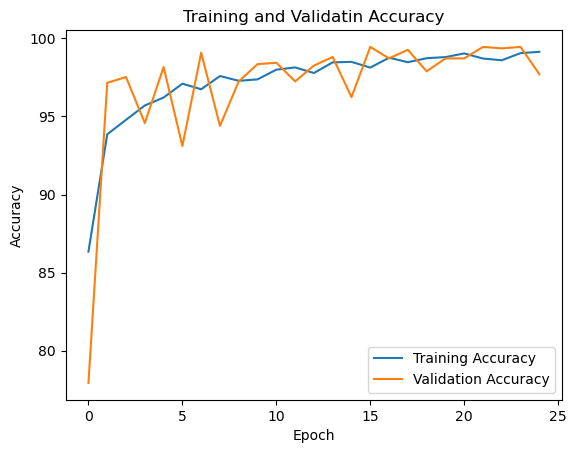

In [23]:
train_acc_list = []
val_acc_list = []

print("Training Started")

for epoch in range(num_epochs):  
    
    model.train()  
    running_loss = 0.0
    correct = 0
    total = 0
    print(f"Epoch {epoch+1}/{num_epochs}")
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training")
    for i, data in enumerate(train_bar, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)  # move inputs and labels to the GPU

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        # Track training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        train_bar.set_postfix({'loss': loss.item(), 'accuracy': 100 * correct / total})
        
        running_loss += loss.item()
        if i % 10000 == 9999:    # print every 10,000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10000))
            running_loss = 0.0
            
    # Print training accuracy
    train_acc = 100 * correct / total
    print(f"Train Accuracy: {train_acc:.2f}%")
    train_acc_list.append(train_acc)

    # Evaluate on Validation set
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation")
        for data in val_bar:

            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)  # move inputs and labels to the GPU

            outputs = model(inputs)
            val_loss += loss_function(outputs, labels).item()

            # Track Validation accuracy
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            val_bar.set_postfix({'loss': loss.item(), 'accuracy': 100 * val_correct / val_total})
            
    # Print Val accuracy
    val_acc = 100 * val_correct / val_total
    print(f"Validation Accuracy: {val_acc:.2f}%")
    val_acc_list.append(val_acc)

print('Finished Training')

# Plot the final training and validaton accuracy
plt.plot(train_acc_list, label='Training Accuracy')
plt.plot(val_acc_list, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validatin Accuracy')
plt.legend()
plt.show()

In [24]:
# Save the trained model
torch.save(model.state_dict(), 'resnet18fruit_V001.pth')

## **Accuracy on Testing Set**

In [25]:
train_accuracy = train_acc_list

# Get the overall accuracy (final accuracy after training)
overall_train_accuracy = train_accuracy[-1]

# Print the overall accuracy
print(f"Overall Training Accuracy: {overall_train_accuracy:.4f}")

Overall Training Accuracy: 99.1338


In [26]:
outputs = model(inputs)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(6)))

model.eval()
test_correct = 0
test_total = 0

test1_bar = tqdm(test_loader,desc="Testing")
with torch.no_grad():

    for data in test1_bar:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_acc = 100 * test_correct / test_total
print(f"Accuracy of the network on the Test images:: {test_acc:.2f}%")

Predicted:  rottenbanana rottenoranges rottenapples freshbanana freshoranges rottenapples


Testing: 100%|██████████| 169/169 [00:13<00:00, 12.67it/s]

Accuracy of the network on the Test images:: 97.07%


In [27]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# no gradients needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)  # Move data to the same device as the model
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy of{:5s} : {:.1f} %".format(classname, accuracy))

Accuracy offreshapples : 99.7 %
Accuracy offreshbanana : 99.5 %
Accuracy offreshoranges : 98.7 %
Accuracy ofrottenapples : 99.2 %
Accuracy ofrottenbanana : 100.0 %
Accuracy ofrottenoranges : 83.6 %


In [28]:
model.eval()
test_total = []
test_pred = []

with torch.no_grad():

    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        test_total.extend(labels.cpu().numpy())
        test_pred.extend(predicted.cpu().numpy())

# Calculate the F1 score
f1 = f1_score(test_total, test_pred, average='weighted')
print(f'F1 score: {f1:.4f}')

# Calculate the confusion matrix
cm = confusion_matrix(test_total, test_pred)
print('Confusion matrix:')
print(cm)

F1 score: 0.9701
Confusion matrix:
[[394   1   0   0   0   0]
 [  0 379   0   0   2   0]
 [  0   0 383   5   0   0]
 [  1   0   0 596   2   2]
 [  0   0   0   0 530   0]
 [  0   0  16  49   1 337]]


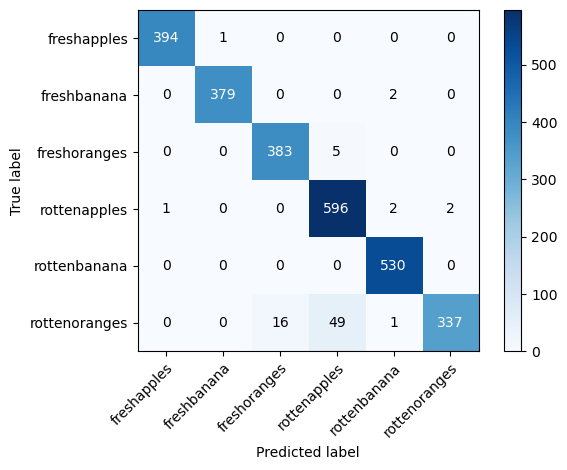

In [29]:
# Plot the confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes, yticklabels=classes,
       ylabel='True label',
       xlabel='Predicted label')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
fmt = 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()
plt.show()